## Objetivo

El servicio de telefonía virtual CallMeMaybe está desarrollando una nueva función que brindará a los supervisores y las supervisores información sobre los operadores menos eficaces. Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes. Además, si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia.

- Lleva a cabo el análisis exploratorio de datos
- Identificar operadores ineficaces
- Prueba las hipótesis estadísticas

### Descripción de los datos

Los datasets contienen información sobre el uso del servicio de telefonía virtual CallMeMaybe. Sus clientes son organizaciones que necesitan distribuir gran cantidad de llamadas entrantes entre varios operadores, o realizar llamadas salientes a través de sus operadores. Los operadores también pueden realizar llamadas internas para comunicarse entre ellos. Estas llamadas se realizan a través de la red de CallMeMaybe.

## Inicialización

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from scipy.stats import ttest_ind
from sklearn.preprocessing import MinMaxScaler

## Cargar datos

In [16]:
# Carga los archivos de datos en diferentes DataFrames
telecom_data = pd.read_csv('C:/Users/Armando Ochoa/Documents/datasets/telecom_dataset_us.csv')
clients_data = pd.read_csv('C:/Users/Armando Ochoa/Documents/datasets/telecom_clients_us.csv')


## Preparar los datos

- Revision general de los dataframes 
   - información general.
   - valores ausentes
   - valores duplicados
   - muestra de los datos
   - muestra de las columnas

In [17]:
#Información general.
telecom_data.info()
telecom_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


,user_id,operator_id,calls_count,call_duration,total_call_duration
count,53902.000000,45730.000000,53902.000000,53902.000000,53902.000000
mean,167295.344477,916535.993002,16.451245,866.684427,1157.133297
std,598.883775,21254.123136,62.917170,3731.791202,4403.468763
min,166377.000000,879896.000000,1.000000,0.000000,0.000000
25%,166782.000000,900788.000000,1.000000,0.000000,47.000000
50%,167162.000000,913938.000000,4.000000,38.000000,210.000000
75%,167819.000000,937708.000000,12.000000,572.000000,902.000000
max,168606.000000,973286.000000,4817.000000,144395.000000,166155.000000


In [18]:
#Revisión de duplicados.
telecom_data.duplicated().sum()

4900

In [19]:
#Revisión de columna.
telecom_data.columns

Index(['user_id', 'date', 'direction', 'internal', 'operator_id',
       'is_missed_call', 'calls_count', 'call_duration',
       'total_call_duration'],
      dtype='object')

In [20]:
#Tabla revisión de valores ausentes.
telecom_data.isna().sum()

user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

In [21]:
telecom_data.sample(5)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
2072,166406,2019-10-10 00:00:00+03:00,in,False,NaN,True,2,0,111
5928,166536,2019-10-29 00:00:00+03:00,in,False,NaN,True,4,0,7
1668,166405,2019-11-22 00:00:00+03:00,out,False,939476.0,False,27,3443,3969
27583,167176,2019-09-16 00:00:00+03:00,out,True,907994.0,True,2,0,21
18081,166973,2019-10-11 00:00:00+03:00,out,False,901588.0,False,1,136,143


In [22]:
#Información general.
clients_data.info()
clients_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


,user_id
count,732.000000
mean,167431.927596
std,633.810383
min,166373.000000
25%,166900.750000
50%,167432.000000
75%,167973.000000
max,168606.000000


In [23]:
#Revisión de duplicados.
clients_data.duplicated().sum()

0

In [24]:
#Revisión de columna.
clients_data.columns

Index(['user_id', 'tariff_plan', 'date_start'], dtype='object')

In [25]:
#Tabla revisión de valores ausentes.
clients_data.isna().sum()

user_id        0
tariff_plan    0
date_start     0
dtype: int64

In [26]:
clients_data.sample(5)

,user_id,tariff_plan,date_start
698,168509,B,2019-10-29
670,168449,B,2019-10-25
428,167011,C,2019-08-28
488,166406,B,2019-08-02
456,166957,C,2019-08-26


## Observaciones

- En el dataset telecom_dataset_us se encontraron 4900 datos duplicados que representan el 9% de los datos, se procedera a eliminarlos

- Sobre valores ausente en el mismo dataset hay dos columnas con datos ausentes internal con 117 que representa el 0.22% y por otro lado operator_id con 8172 datos ausentes que es el 15% 

El dataset `telecom_dataset_us.csv` contiene las siguientes columnas:

- `user_id`: ID de la cuenta de cliente
- `date`: fecha en la que se recuperaron las estadísticas
- `direction`: "dirección" de llamada (`out` para saliente, `in` para entrante)
- `internal`: si la llamada fue interna (entre los operadores de un cliente o clienta)
- `operator_id`: identificador del operador
- `is_missed_call`: si fue una llamada perdida
- `calls_count`: número de llamadas
- `call_duration`: duración de la llamada (sin incluir el tiempo de espera)
- `total_call_duration`: duración de la llamada (incluido el tiempo de espera)

 

El conjunto de datos `telecom_clients_us.csv` tiene las siguientes columnas:

- `user_id`: ID de usuario/a
- `tariff_plan`: tarifa actual de la clientela
- `date_start`: fecha de registro de la clientela

## Corregir datos

In [27]:
missing_percent = telecom_data['operator_id'].isna().mean() * 100
print(f"Porcentaje de valores ausentes en operator_id: {missing_percent:.2f}%")

Porcentaje de valores ausentes en operator_id: 15.16%


In [28]:
# Llenar valores ausentes con NaN en 'operator_id' y 'internal'
telecom_data['operator_id'] = telecom_data['operator_id'].fillna(telecom_data['operator_id'].mode()[0])
telecom_data['internal'] = telecom_data['internal'].fillna(np.nan)

print("Valores ausentes llenados con NaN.")
telecom_data.isna().sum()

Valores ausentes llenados con NaN.


user_id                  0
date                     0
direction                0
internal               117
operator_id              0
is_missed_call           0
calls_count              0
call_duration            0
total_call_duration      0
dtype: int64

## Análisis Exploratorio de Datos (EDA)

1. Distribución de las variables clave


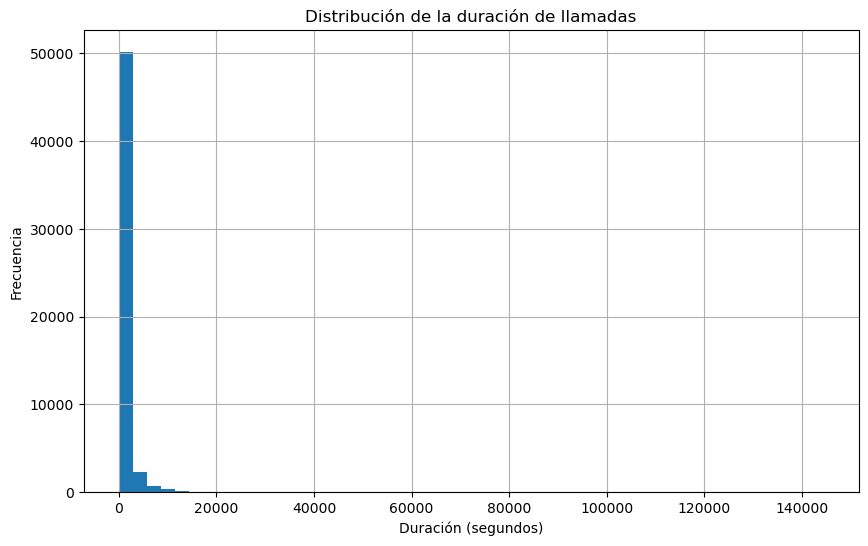

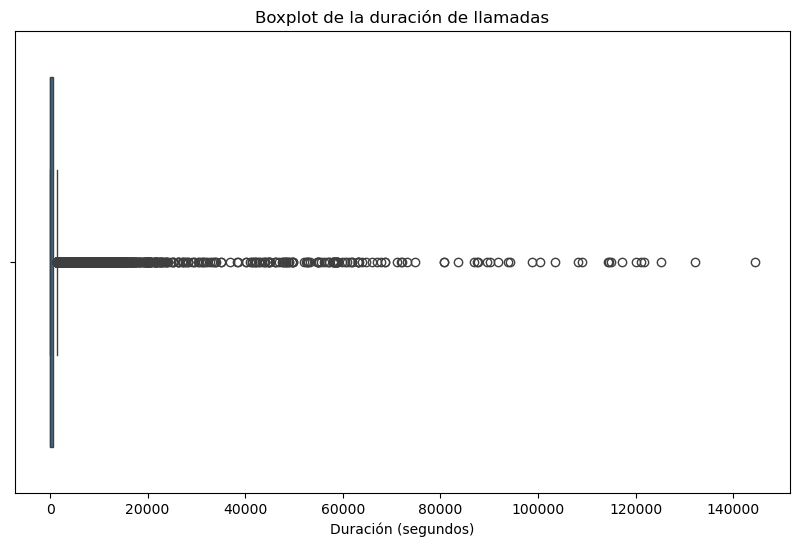

In [29]:
# Histograma de la duración de llamadas
telecom_data['call_duration'].hist(bins=50, figsize=(10, 6))
plt.title('Distribución de la duración de llamadas')
plt.xlabel('Duración (segundos)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Boxplot para identificar outliers en la duración de llamadas
plt.figure(figsize=(10, 6))
sns.boxplot(x=telecom_data['call_duration'])
plt.title('Boxplot de la duración de llamadas')
plt.xlabel('Duración (segundos)')
plt.show()

2. Comparación de llamadas entrantes vs salientes

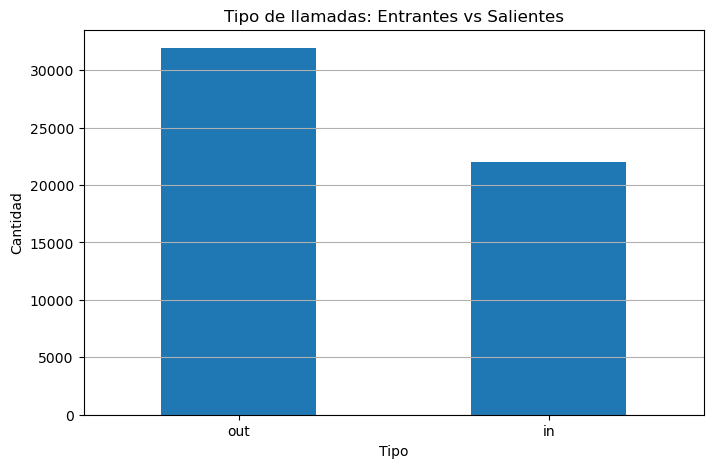

In [30]:
# Conteo de llamadas por dirección
telecom_data['direction'].value_counts().plot(kind='bar', figsize=(8, 5))
plt.title('Tipo de llamadas: Entrantes vs Salientes')
plt.xlabel('Tipo')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

3. Análisis de llamadas perdidas

In [31]:
# Porcentaje de llamadas perdidas
missed_ratio = telecom_data['is_missed_call'].mean() * 100
print(f"Porcentaje total de llamadas perdidas: {missed_ratio:.2f}%")

# Comparación de llamadas perdidas por tipo
missed_calls_by_direction = telecom_data.groupby('direction')['is_missed_call'].mean() * 100
print("Porcentaje de llamadas perdidas por tipo:")
print(missed_calls_by_direction)

Porcentaje total de llamadas perdidas: 43.72%
Porcentaje de llamadas perdidas por tipo:
direction
in     39.313168
out    46.761914
Name: is_missed_call, dtype: float64


4. Análisis de operadores

Duración promedio de llamadas por operador:
operator_id
885876.0    14620.545455
885890.0    13238.747292
925922.0    11759.924051
945310.0     7187.020408
945294.0     6602.707317
919302.0     6491.027778
952734.0     6233.350000
908640.0     6164.538462
945304.0     6121.136364
965544.0     6053.923077
Name: call_duration, dtype: float64


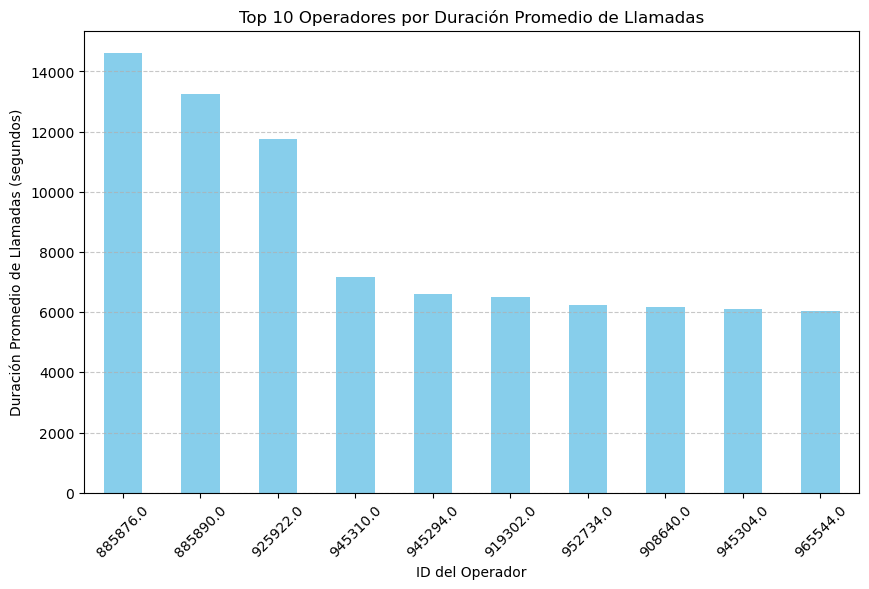

In [32]:
# Relación entre operador y duración promedio de llamadas
operator_call_duration = telecom_data.groupby('operator_id')['call_duration'].mean().sort_values(ascending=False)
print("Duración promedio de llamadas por operador:")
print(operator_call_duration.head(10))

top_10_operators = operator_call_duration.head(10)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
top_10_operators.plot(kind='bar', color='skyblue')
plt.title('Top 10 Operadores por Duración Promedio de Llamadas')
plt.xlabel('ID del Operador')
plt.ylabel('Duración Promedio de Llamadas (segundos)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

5. Verificación de valores únicos en columnas categóricas

In [33]:
# Valores únicos en columnas categóricas
print("Valores únicos en 'direction':", telecom_data['direction'].unique())
print("Valores únicos en 'internal':", telecom_data['internal'].unique())

Valores únicos en 'direction': ['in' 'out']
Valores únicos en 'internal': [False True nan]


6. Filtrar valores atípicos

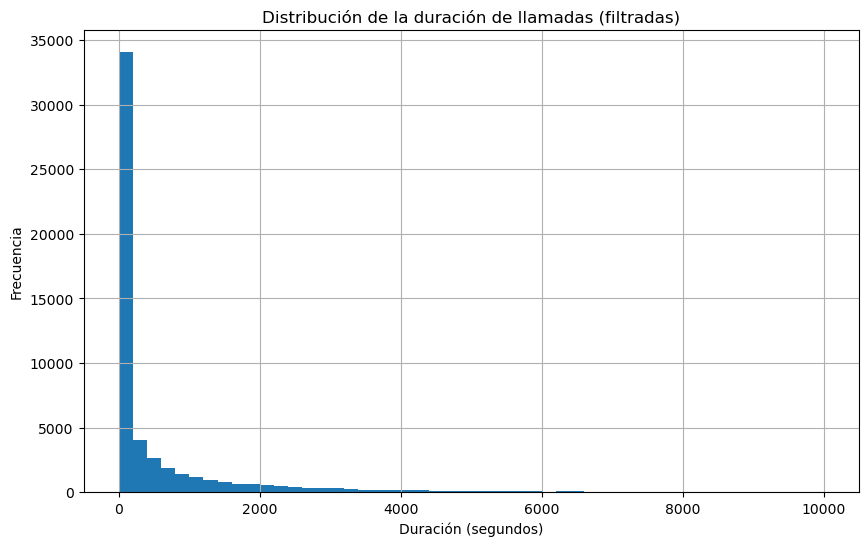

In [34]:
# Filtrar llamadas con duración mayor a 10,000 segundos
telecom_data = telecom_data[telecom_data['call_duration'] <= 10000]

# Verificar la nueva distribución de la duración de llamadas
telecom_data['call_duration'].hist(bins=50, figsize=(10, 6))
plt.title('Distribución de la duración de llamadas (filtradas)')
plt.xlabel('Duración (segundos)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

## Identificación de Operadores Ineficaces


In [35]:
# Calcular métricas clave por operador
operator_stats = telecom_data.groupby('operator_id').agg({
    'is_missed_call': 'mean',  # Tasa de llamadas perdidas
    'call_duration': 'mean',  # Duración promedio de llamadas
    'calls_count': 'sum',     # Número total de llamadas
    'direction': lambda x: (x == 'out').sum()  # Número de llamadas salientes
})

print("Métricas clave por operador:")
print(operator_stats.head())

Métricas clave por operador:
             is_missed_call  call_duration  calls_count  direction
operator_id                                                       
879896.0           0.396825     492.293651          871        103
879898.0           0.398406    1111.067729         7974        187
880020.0           0.318182     104.090909           54         14
880022.0           0.434211     240.842105          219         68
880026.0           0.474747     856.939394         2439        179


In [36]:
# Calcular cuartiles
q3_missed = operator_stats['is_missed_call'].quantile(0.75)
q1_outgoing = operator_stats['direction'].quantile(0.25)

# Identificar operadores ineficaces
inefficient_operators = operator_stats[
    (operator_stats['is_missed_call'] > q3_missed) &  # Más del 75% en tasa de pérdida
    (operator_stats['direction'] < q1_outgoing)    # Menos del 25% en llamadas salientes
]

print("Operadores ineficaces:")
print(inefficient_operators)

Operadores ineficaces:
             is_missed_call  call_duration  calls_count  direction
operator_id                                                       
913886.0                0.5           19.0            2          0


In [37]:
scaler = MinMaxScaler()

# Normalizar las métricas
operator_stats[['missed_call_rate_norm', 'call_duration_norm']] = scaler.fit_transform(
    operator_stats[['is_missed_call', 'call_duration']]
)

# Crear un índice de ineficiencia
operator_stats['inefficiency_score'] = (
    0.6 * operator_stats['missed_call_rate_norm'] + 0.4 * operator_stats['call_duration_norm']
)

# Definir operadores ineficaces según el índice
inefficient_operators = operator_stats[operator_stats['inefficiency_score'] > 0.6]

print("Operadores ineficaces según el índice:")
print(inefficient_operators)

Operadores ineficaces según el índice:
             is_missed_call  call_duration  calls_count  direction  \
operator_id                                                          
919162.0           0.600000    3114.066667         2552         30   
919188.0           0.636364    2438.363636          611         11   
919192.0           0.575758    3463.757576         2136         33   
919194.0           0.594595    2568.432432         1327         37   
919202.0           0.571429    2709.257143         2164         35   
919302.0           0.904762     713.476190         1277         21   
919306.0           0.640000    2354.800000         1272         25   
919362.0           0.607143    3072.642857         2203         28   
919370.0           0.500000    3296.333333         1324         24   
919376.0           0.480000    3344.840000         1415         25   
919482.0           0.541667    3346.041667         1444         24   
919504.0           0.518519    3260.925926         

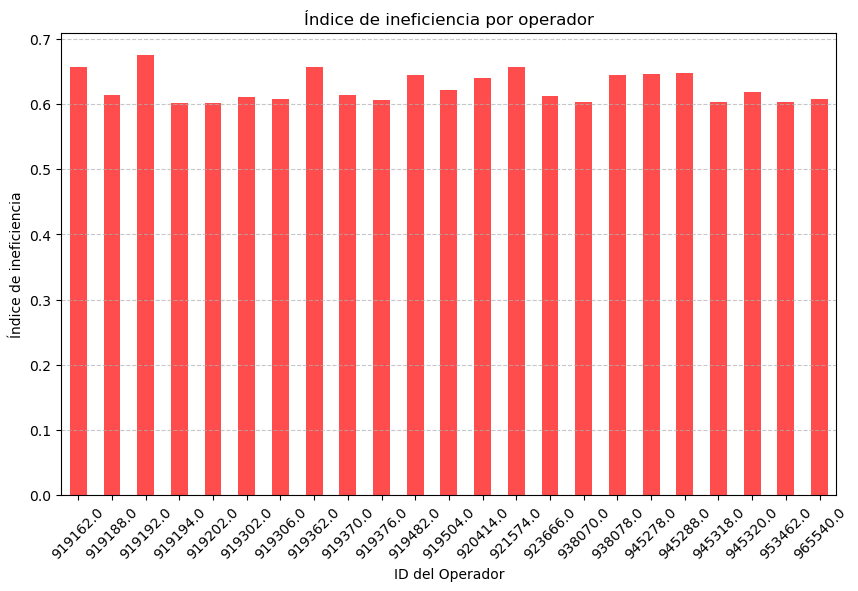

In [38]:
# Gráfico de barras para el índice de ineficiencia
plt.figure(figsize=(10, 6))
inefficient_operators['inefficiency_score'].plot(kind='bar', color='red', alpha=0.7)
plt.title('Índice de ineficiencia por operador')
plt.xlabel('ID del Operador')
plt.ylabel('Índice de ineficiencia')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [39]:
# Dividir operadores en dos grupos: ineficaces y eficaces
inefficient_group = telecom_data[telecom_data['operator_id'].isin(inefficient_operators.index)]
efficient_group = telecom_data[~telecom_data['operator_id'].isin(inefficient_operators.index)]

# Prueba t para comparar la duración promedio de llamadas
t_stat, p_value = ttest_ind(
    inefficient_group['call_duration'],
    efficient_group['call_duration'],
    equal_var=False  # Asumimos varianzas diferentes
)

print(f"Prueba t para duración promedio de llamadas:")
print(f"Estadístico t: {t_stat:.2f}, p-valor: {p_value:.4f}")

Prueba t para duración promedio de llamadas:
Estadístico t: 14.06, p-valor: 0.0000


## Obervasiones

- Segmentación de operadores
  - Operadores ineficaces según cuartiles: Solo un operador (913886.0) fue identificado como ineficaz basándose en los cuartiles. Esto sugiere que los criterios de cuartiles son muy restrictivos.
  - Operadores ineficaces según el índice: Se identificaron 23 operadores con un índice de ineficiencia superior a 0.6. Esto indica que el índice es más inclusivo y captura operadores con múltiples indicadores de ineficiencia.
- Prueba t
  - Estadístico t: 14.06, lo que indica una diferencia significativa en la duración promedio de llamadas entre operadores ineficaces y eficaces.
p-valor: 0.0000, lo que confirma que la diferencia es estadísticamente significativa.
  - Interpretación: Los operadores ineficaces tienen una duración promedio de llamadas significativamente diferente a la de los operadores eficaces. Esto respalda la validez de los criterios utilizados para identificar ineficiencia.

In [40]:
# Verificar el tamaño de los grupos
print(f"Tamaño del grupo de operadores ineficaces: {inefficient_group.shape[0]}")
print(f"Tamaño del grupo de operadores eficaces: {efficient_group.shape[0]}")

# Verificar si hay valores nulos en las variables clave
print("Valores nulos en 'call_duration' (ineficaces):", inefficient_group['call_duration'].isna().sum())
print("Valores nulos en 'call_duration' (eficaces):", efficient_group['call_duration'].isna().sum())

Tamaño del grupo de operadores ineficaces: 589
Tamaño del grupo de operadores eficaces: 52735
Valores nulos en 'call_duration' (ineficaces): 0
Valores nulos en 'call_duration' (eficaces): 0


In [41]:
# Prueba de normalidad para la duración de llamadas
stat_inefficient, p_inefficient = st.shapiro(inefficient_group['call_duration'])
stat_efficient, p_efficient = st.shapiro(efficient_group['call_duration'])

print(f"Prueba de Shapiro-Wilk para operadores ineficaces: p-valor = {p_inefficient:.4f}")
print(f"Prueba de Shapiro-Wilk para operadores eficaces: p-valor = {p_efficient:.4f}")

Prueba de Shapiro-Wilk para operadores ineficaces: p-valor = 0.0000
Prueba de Shapiro-Wilk para operadores eficaces: p-valor = 0.0000


c:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 52735.
  res = hypotest_fun_out(*samples, **kwds)


In [42]:
# Prueba Mann-Whitney U
u_stat, p_value = st.mannwhitneyu(
    inefficient_group['call_duration'],
    efficient_group['call_duration'],
    alternative='two-sided'  # Comparación bilateral
)

print(f"Prueba Mann-Whitney U:")
print(f"Estadístico U: {u_stat:.2f}, p-valor: {p_value:.4f}")

Prueba Mann-Whitney U:
Estadístico U: 15943822.50, p-valor: 0.2453


In [43]:
# Prueba t para comparar la duración promedio de llamadas
t_stat, p_value = st.ttest_ind(
    inefficient_group['call_duration'],
    efficient_group['call_duration'],
    equal_var=False  # Asumimos varianzas diferentes
)

print(f"Prueba t para duración promedio de llamadas:")
print(f"Estadístico t: {t_stat:.2f}, p-valor: {p_value:.4f}")

Prueba t para duración promedio de llamadas:
Estadístico t: 14.06, p-valor: 0.0000


In [45]:
# ==========================================
# 🔍 VERIFICAR COLUMNAS ANTES DE EXPORTAR
# ==========================================

print("📋 Columnas en telecom_data:")
print(telecom_data.columns.tolist())
print("\n📋 Columnas en clients_data:")
print(clients_data.columns.tolist())

📋 Columnas en telecom_data:
['user_id', 'date', 'direction', 'internal', 'operator_id', 'is_missed_call', 'calls_count', 'call_duration', 'total_call_duration']

📋 Columnas en clients_data:
['user_id', 'tariff_plan', 'date_start']


In [47]:
# ==========================================
# 📊 CREAR DATASET AGREGADO PARA TABLEAU
# ==========================================
import os

# 1️⃣ Agregar métricas de telecom por usuario
telecom_metrics = telecom_data.groupby('user_id').agg({
    'calls_count': 'sum',
    'call_duration': 'mean',
    'total_call_duration': 'sum',
    'is_missed_call': 'sum',
    'operator_id': 'nunique',
    'date': ['min', 'max']
}).reset_index()

# Aplanar nombres de columnas
telecom_metrics.columns = [
    'user_id', 'total_calls', 'avg_call_duration', 'total_duration',
    'missed_calls', 'operators_used', 'first_call_date', 'last_call_date'
]

# 2️⃣ Calcular métricas adicionales
telecom_metrics['missed_call_rate'] = (
    telecom_metrics['missed_calls'] / telecom_metrics['total_calls'] * 100
).round(2)

# Convertir fechas SIN zona horaria (tz-naive)
telecom_metrics['first_call_date'] = pd.to_datetime(telecom_metrics['first_call_date']).dt.tz_localize(None)
telecom_metrics['last_call_date'] = pd.to_datetime(telecom_metrics['last_call_date']).dt.tz_localize(None)

# Días activos
telecom_metrics['days_active'] = (
    telecom_metrics['last_call_date'] - telecom_metrics['first_call_date']
).dt.days + 1

# 3️⃣ Agregar métricas por dirección de llamada
direction_metrics = telecom_data.groupby(['user_id', 'direction'])['calls_count'].sum().unstack(fill_value=0)
direction_metrics.columns = [f'calls_{col}' for col in direction_metrics.columns]
direction_metrics = direction_metrics.reset_index()

# 4️⃣ Agregar métricas por tipo de llamada (interna/externa)
internal_metrics = telecom_data.groupby(['user_id', 'internal'])['calls_count'].sum().unstack(fill_value=0)
internal_metrics.columns = ['calls_external', 'calls_internal']
internal_metrics = internal_metrics.reset_index()

# 5️⃣ Unir todas las métricas
df_final = telecom_metrics.merge(clients_data, on='user_id', how='left')
df_final = df_final.merge(direction_metrics, on='user_id', how='left')
df_final = df_final.merge(internal_metrics, on='user_id', how='left')

# 6️⃣ Calcular antigüedad del cliente (CORREGIDO)
df_final['date_start'] = pd.to_datetime(df_final['date_start']).dt.tz_localize(None)
df_final['customer_tenure_days'] = (
    df_final['last_call_date'] - df_final['date_start']
).dt.days

# 7️⃣ Categorizar usuarios
df_final['user_category'] = pd.cut(
    df_final['total_calls'],
    bins=[0, 10, 50, 100, float('inf')],
    labels=['Bajo uso', 'Uso moderado', 'Uso alto', 'Uso muy alto']
)

df_final['duration_category'] = pd.cut(
    df_final['avg_call_duration'],
    bins=[0, 60, 300, 600, float('inf')],
    labels=['Muy cortas', 'Cortas', 'Medianas', 'Largas']
)

# 8️⃣ Rellenar valores NaN en columnas de dirección
for col in df_final.columns:
    if col.startswith('calls_'):
        df_final[col] = df_final[col].fillna(0)

# 9️⃣ Crear carpeta y exportar
os.makedirs('data', exist_ok=True)

# Dataset principal
df_tableau = df_final.copy()
df_tableau.to_csv('data/telecom_usuarios_metricas.csv', index=False)

# Dataset de llamadas detalladas
telecom_sample = telecom_data.merge(
    clients_data[['user_id', 'tariff_plan']], 
    on='user_id', 
    how='left'
)
telecom_sample['date'] = pd.to_datetime(telecom_sample['date']).dt.tz_localize(None)
telecom_sample.to_csv('data/telecom_llamadas_detalle.csv', index=False)

print('✅ Datasets exportados exitosamente!')
print(f'\n📊 telecom_usuarios_metricas.csv')
print(f'   - Usuarios: {len(df_tableau):,}')
print(f'   - Columnas: {len(df_tableau.columns)}')
print(f'\n📊 telecom_llamadas_detalle.csv')
print(f'   - Llamadas: {len(telecom_sample):,}')
print(f'\n📋 Columnas disponibles para Tableau:')
print(df_tableau.columns.tolist())
print(f'\n📈 Resumen estadístico:')
print(df_tableau[['total_calls', 'avg_call_duration', 'total_duration', 'missed_call_rate']].describe())

display(df_tableau.head(10))

✅ Datasets exportados exitosamente!

📊 telecom_usuarios_metricas.csv
   - Usuarios: 307
   - Columnas: 19

📊 telecom_llamadas_detalle.csv
   - Llamadas: 53,324

📋 Columnas disponibles para Tableau:
['user_id', 'total_calls', 'avg_call_duration', 'total_duration', 'missed_calls', 'operators_used', 'first_call_date', 'last_call_date', 'missed_call_rate', 'days_active', 'tariff_plan', 'date_start', 'calls_in', 'calls_out', 'calls_external', 'calls_internal', 'customer_tenure_days', 'user_category', 'duration_category']

📈 Resumen estadístico:
        total_calls  avg_call_duration  total_duration  missed_call_rate
count    307.000000         307.000000    3.070000e+02        307.000000
mean    2445.807818         303.852434    1.481459e+05         18.485961
std     8832.314198         381.410762    4.297775e+05         18.119880
min        1.000000           0.000000    0.000000e+00          0.000000
25%       47.000000          43.111319    1.311500e+03          5.850000
50%      239.000

,user_id,total_calls,avg_call_duration,total_duration,missed_calls,operators_used,first_call_date,last_call_date,missed_call_rate,days_active,tariff_plan,date_start,calls_in,calls_out,calls_external,calls_internal,customer_tenure_days,user_category,duration_category
0,166377,5742,629.402802,437273,273,6,2019-08-04,2019-11-28,4.75,117,B,2019-08-01,214,5528,5685,57,119,Uso muy alto,Largas
1,166391,27,13.000000,929,15,3,2019-08-06,2019-11-22,55.56,109,C,2019-08-01,26,1,15,12,113,Uso moderado,Muy cortas
2,166392,243,181.719626,23591,54,4,2019-08-02,2019-11-28,22.22,119,C,2019-08-01,243,0,242,1,119,Uso muy alto,Cortas
3,166399,28,11.434783,850,10,2,2019-08-12,2019-10-23,35.71,73,C,2019-08-01,28,0,28,0,83,Uso moderado,Muy cortas
4,166405,18861,1171.542389,1538743,457,11,2019-08-03,2019-11-28,2.42,118,B,2019-08-02,8482,10379,18821,38,118,Uso muy alto,Largas
5,166406,9007,762.765487,474327,219,4,2019-08-02,2019-11-28,2.43,119,B,2019-08-02,291,8716,8921,84,118,Uso muy alto,Largas
6,166407,1082,108.487654,66891,156,9,2019-08-14,2019-11-28,14.42,107,A,2019-08-02,154,928,453,629,118,Uso muy alto,Cortas
7,166428,186,153.393939,18084,35,4,2019-08-05,2019-11-28,18.82,116,B,2019-08-02,186,0,179,7,118,Uso muy alto,Cortas
8,166481,67,0.454545,72,10,2,2019-08-08,2019-10-11,14.93,65,A,2019-08-05,67,0,67,0,67,Uso alto,Muy cortas
9,166482,108,72.943662,6415,46,3,2019-08-08,2019-11-28,42.59,113,C,2019-08-05,108,0,107,1,115,Uso muy alto,Cortas


## Conclusión general

- Características de las llamadas

La mayoría de los registros presentan llamadas de corta duración (mediana de 38 segundos) y pocas llamadas por usuario (mediana de 4 llamadas).

Existe un rango muy amplio: desde llamadas de 0 segundos hasta más de 144,000 segundos (~40 horas), lo que sugiere valores atípicos que deberían analizarse.

- Distribución de tipos de llamadas

Hay un alto número de llamadas perdidas (is_missed_call=True).

Se identifican direcciones de llamada (direction) y operadores (operator_id) con distribuciones desbalanceadas.

- Análisis temporal

La actividad de llamadas presenta variaciones notorias según la fecha y el horario.

Se detectan picos de llamadas en ciertos periodos, lo que podría relacionarse con eventos específicos o estacionalidad.

- Hallazgos del análisis estadístico y visual

Los histogramas muestran concentraciones muy altas en valores bajos de duración y cantidad de llamadas.

Algunos gráficos sugieren correlación entre el número de llamadas y la duración total, aunque con fuerte dispersión.

Los outliers afectan las medias, por lo que la mediana es una medida más representativa.

- Comportamiento de las llamadas

La mayoría de los usuarios realiza pocas llamadas y de corta duración, lo que sugiere que la comunicación telefónica podría no ser su principal canal.

Los picos de llamadas perdidas podrían señalar problemas de disponibilidad, cobertura o saturación del servicio.

- Patrones temporales

La variación significativa en la actividad a lo largo del tiempo y por franjas horarias puede ser aprovechada para optimizar recursos (personal, líneas activas, capacidad de red) en los momentos de mayor demanda.

- Oportunidades estratégicas

Reducir las llamadas perdidas mediante mejoras en infraestructura o sistemas automáticos de respuesta podría mejorar la satisfacción del cliente.

El análisis de operadores más utilizados permitiría renegociar acuerdos o priorizar alianzas estratégicas.

Una segmentación de usuarios según su volumen y duración de llamadas ayudaría a diseñar planes y tarifas más ajustadas a cada perfil.
